In [178]:
from bs4 import BeautifulSoup
import requests
import requests_cache
from PandasBasketball import pandasbasketball as pb
from PandasBasketball.stats import player_stats, team_stats, player_gamelog, n_days
# from PandasBasketball.errors import StatusCode404, TableNonExistent 

In [179]:
requests_cache.install_cache('request_cache')

In [180]:
# Generate list of letter directories for player names (by their last names)
import string

letters = string.ascii_lowercase
players_letter_dirs = [f"http://www.basketball-reference.com/players/{letter}/" for letter in letters]
players_letter_dirs[:2]

['http://www.basketball-reference.com/players/a/',
 'http://www.basketball-reference.com/players/b/']

In [181]:
reqs = [requests.get(url) for url in players_letter_dirs]
reqs[:4]

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]

In [182]:
requests.get('http://www.basketball-reference.com/players/f').from_cache

True

## Scrape player list pages for all names and the file name conventions for each

In [183]:
'''
The player name to file naming convention should be a dictionary with player name being key.
This will give a user the ability to lookup naming convention by name
'''
from bs4 import BeautifulSoup
from PandasBasketball.stats import get_data_master

f_request = requests.get("http://www.basketball-reference.com/players/f")
soup = BeautifulSoup(f_request.text, "html.parser")
player_table = soup.find("table", id="players")
df = get_data_master(player_table, "player")
df.head(1)

Player  From    To  Pos   Ht   Wt    Birth Date Colleges
0  Joe Fabel  1947  1947  F-G  6-1  190  May 15, 1917     Pitt

## Retrieve full list of players all time and their filename encodings

In [184]:
# Generate list of player tables, one from each letter directory
players_tables = []
for letter_dir in players_letter_dirs:
    r = requests.get(letter_dir)
    soup = BeautifulSoup(r.text, "html.parser")
    players_table = soup.find("table", id="players")
    players_tables.append(players_table)

In [185]:
# Generate dictionary mapping every player name to their respective name encoding

player_dict = {}

for players_table in players_tables:
    players_name_rows = players_table.find("tbody").find_all("th")
    filenames = [row["data-append-csv"] for row in players_name_rows]

    for row in players_name_rows:
        split_name = row.a.text.split()
        first = split_name[0]
        last = split_name[-1]
        encoding = row["data-append-csv"]
        player_dict[f"{first} {last}"] = encoding

player_dict    



{'Alaa Abdelnaby': 'abdelal01',
 'Zaid Abdul-Aziz': 'abdulza01',
 'Kareem Abdul-Jabbar': 'abdulka01',
 'Mahmoud Abdul-Rauf': 'abdulma02',
 'Tariq Abdul-Wahad': 'abdulta01',
 'Shareef Abdur-Rahim': 'abdursh01',
 'Tom Abernethy': 'abernto01',
 'Forest Able': 'ablefo01',
 'John Abramovic': 'abramjo01',
 'Álex Abrines': 'abrinal01',
 'Alex Acker': 'ackeral01',
 'Don Ackerman': 'ackerdo01',
 'Mark Acres': 'acresma01',
 'Bud Acton': 'actonbu01',
 'Quincy Acy': 'acyqu01',
 'Alvan Adams': 'adamsal01',
 'Don Adams': 'adamsdo01',
 'George Adams': 'adamsge01',
 'Hassan Adams': 'adamsha01',
 'Jaylen Adams': 'adamsja01',
 'Jordan Adams': 'adamsjo01',
 'Michael Adams': 'adamsmi01',
 'Steven Adams': 'adamsst01',
 'Rafael Addison': 'addisra01',
 'Bam Adebayo': 'adebaba01',
 'Deng Adel': 'adelde01',
 'Rick Adelman': 'adelmri01',
 'Jeff Adrien': 'adrieje01',
 'Arron Afflalo': 'afflaar01',
 'Maurice Ager': 'agerma01',
 'Mark Aguirre': 'aguirma01',
 'Blake Ahearn': 'ahearbl01',
 'Danny Ainge': 'aingeda01'

In [186]:
# Get list of every player page to be scraped
full_player_urls = []
for letter_dir in players_letter_dirs:
    for encoding in player_dict.values():
        if encoding.startswith(letter_dir[-2]):
            full_player_urls.append(letter_dir+encoding+".html")
full_player_urls[50:6000:200]

['http://www.basketball-reference.com/players/a/alexaky01.html',
 'http://www.basketball-reference.com/players/b/battljo01.html',
 'http://www.basketball-reference.com/players/b/bradldu01.html',
 'http://www.basketball-reference.com/players/c/cannola01.html',
 'http://www.basketball-reference.com/players/c/corleke01.html',
 'http://www.basketball-reference.com/players/d/dickehe01.html',
 'http://www.basketball-reference.com/players/e/evansre01.html',
 'http://www.basketball-reference.com/players/g/garriki01.html',
 'http://www.basketball-reference.com/players/h/hagangl01.html',
 'http://www.basketball-reference.com/players/h/higgske01.html',
 'http://www.basketball-reference.com/players/j/jamesju01.html',
 'http://www.basketball-reference.com/players/k/keefead01.html',
 'http://www.basketball-reference.com/players/l/lawsoja01.html',
 'http://www.basketball-reference.com/players/m/markkla01.html',
 'http://www.basketball-reference.com/players/m/mercero01.html',
 'http://www.basketball-r

In [187]:
# Generate full player dataframe concatenated
import random
import pandas as pd

dfs = [player_stats(requests.get(url), "per_minute") for url in random.sample(full_player_urls, 5)]
all_stats = pd.concat(dfs)
all_stats[::5]
#     print(url)

Season Age   Tm   Lg Pos   G  GS    MP   FG   FGA  ...  BLK   PF   PTS  \
0   1973-74  22  KCO  NBA  SG   5        45  3.2   8.0  ...  0.0  3.2   9.6   
4   2004-05  26  MIL  NBA  PF  54   0   903  5.3  11.6  ...  0.5  3.8  13.4   
3   1990-91  25  NYK  NBA  PG  72  21  1595  5.6  11.5  ...  0.2  1.8  14.2   
8   1995-96  30  IND  NBA  PG  81  81  2643  4.0   8.5  ...  0.1  2.1  11.0   
13  1998-99  33  IND  NBA  PG  49  49  1382  3.6   8.6  ...  0.1  1.5   9.7   
18  2001-02  36  NYK  NBA  PG  82  82  2367  4.0   9.0  ...  0.0  2.5  10.4   

     3P  3PA   3P%   2P   2PA   2P%  TOV  
0   NaN  NaN   NaN  NaN   NaN   NaN  NaN  
4   0.0  0.2  .000  5.3  11.4  .465  2.5  
3   0.3  1.2  .255  5.3  10.3  .519  3.0  
8   0.9  2.0  .430  3.2   6.5  .486  2.7  
13  0.8  2.7  .311  2.8   5.9  .469  2.6  
18  1.2  3.0  .405  2.8   6.0  .456  2.3  

[6 rows x 29 columns]

In [188]:
import matplotlib.pyplot as plt
import sqlite3

In [189]:
conn = sqlite3.connect('all_player_stats.db')
c = conn.cursor()

In [191]:
sql = "show tables"
# pd.read_sql(sql, conn)

In [192]:
sql = "select * from all_players"
c.execute(sql).fetchall()[0][:5]

(0, '2010-11', '23', 'TOT', 'NBA')

In [193]:
harden = pd.concat([pb.get_player_gamelog("hardeja01","2010"),pb.get_player_gamelog("hardeja01","2011"),pb.get_player_gamelog("hardeja01","2012"),
                   pb.get_player_gamelog("hardeja01","2013"),pb.get_player_gamelog("hardeja01","2014"),pb.get_player_gamelog("hardeja01","2015"),
                   pb.get_player_gamelog("hardeja01","2016"),pb.get_player_gamelog("hardeja01","2017"),pb.get_player_gamelog("hardeja01","2018"),
                   pb.get_player_gamelog("hardeja01","2019")])
harden.tail()

G        Date     Age   Tm     Opp          GS     MP  FG  ... DRB TRB  \
Rk                                                              ...           
78  74  2019-04-02  29-219  HOU  @  SAC  W (+25)  1  29:28  12  ...   3   3   
79  75  2019-04-03  29-220  HOU  @  LAC  W (+32)  1  30:21   9  ...   6   7   
80  76  2019-04-05  29-222  HOU     NYK  W (+24)  1  29:12   8  ...   8   9   
81  77  2019-04-07  29-224  HOU     PHO  W (+36)  1  29:00  10  ...  13  13   
82  78  2019-04-09  29-226  HOU  @  OKC   L (-1)  1  36:58  11  ...   9  10   

   AST STL BLK TOV PF PTS  GmSc  +/-  
Rk                                    
78  10   1   0   2  2  36  33.2  +29  
79   7   0   0   6  3  31  23.5  +16  
80   8   1   1   3  2  26  21.1  +29  
81   9   2   0   6  3  30  28.4  +39  
82   3   1   1   4  4  39  25.0   +1  

[5 rows x 29 columns]

In [194]:
harden

G        Date     Age   Tm     Opp          GS     MP  FG  ... DRB TRB  \
Rk                                                              ...           
1    1  2009-10-28  20-063  OKC     SAC  W (+13)  0  12:59   2  ...   2   2   
2    2  2009-10-30  20-065  OKC  @  DET   W (+8)  0  16:38   1  ...   1   2   
3    3  2009-11-01  20-067  OKC     POR   L (-9)  0  17:52   2  ...   2   3   
4    4  2009-11-03  20-069  OKC     LAL   L (-3)  0  17:04   3  ...   1   1   
5    5  2009-11-06  20-072  OKC  @  HOU  L (-11)  0  10:02   2  ...   1   1   
..  ..         ...     ...  ... ..  ...      ... ..    ...  ..  ...  ..  ..   
78  74  2019-04-02  29-219  HOU  @  SAC  W (+25)  1  29:28  12  ...   3   3   
79  75  2019-04-03  29-220  HOU  @  LAC  W (+32)  1  30:21   9  ...   6   7   
80  76  2019-04-05  29-222  HOU     NYK  W (+24)  1  29:12   8  ...   8   9   
81  77  2019-04-07  29-224  HOU     PHO  W (+36)  1  29:00  10  ...  13  13   
82  78  2019-04-09  29-226  HOU  @  OKC   L (-1)  1  36:58  11  ...   9  10   

   AST STL BLK TOV PF PTS  GmSc  +/-  
Rk                                    
1    0   0   0   0  3   5   3.8   -5  
2    8   0   0   0  3   2   3.6  +17  
3    2   1   1   1  2   6   3.1   +4  
4    3   1   0   0  2   9   6.5  +16  
5    1   0   0   1  1   4   2.3   -8  
..  ..  ..  ..  .. ..  ..   ...  ...  
78  10   1   0   2  2  36  33.2  +29  
79   7   0   0   6  3  31  23.5  +16  
80   8   1   1   3  2  26  21.1  +29  
81   9   2   0   6  3  30  28.4  +39  
82   3   1   1   4  4  39  25.0   +1  

[804 rows x 29 columns]

In [195]:
type(harden.PTS)

pandas.core.series.Series

In [196]:
from pandas_profiling import ProfileReport

In [197]:
harden.reset_index(inplace=True)

In [199]:
harden.head(10)

Rk   G        Date     Age   Tm     Opp          GS     MP  ... DRB TRB  \
0   1   1  2009-10-28  20-063  OKC     SAC  W (+13)  0  12:59  ...   2   2   
1   2   2  2009-10-30  20-065  OKC  @  DET   W (+8)  0  16:38  ...   1   2   
2   3   3  2009-11-01  20-067  OKC     POR   L (-9)  0  17:52  ...   2   3   
3   4   4  2009-11-03  20-069  OKC     LAL   L (-3)  0  17:04  ...   1   1   
4   5   5  2009-11-06  20-072  OKC  @  HOU  L (-11)  0  10:02  ...   1   1   
5   6   6  2009-11-08  20-074  OKC     ORL  W (+28)  0  19:13  ...   3   4   
6   7   7  2009-11-10  20-076  OKC  @  SAC   L (-3)  0  19:24  ...   4   4   
7   8   8  2009-11-11  20-077  OKC  @  LAC   W (+4)  0  23:54  ...   5   5   
8   9   9  2009-11-14  20-080  OKC  @  SAS   W (+3)  0  19:57  ...   1   2   
9  10  10  2009-11-15  20-081  OKC     LAC   L (-8)  0  17:38  ...   2   3   

  AST STL BLK TOV PF PTS  GmSc  +/-  
0   0   0   0   0  3   5   3.8   -5  
1   8   0   0   0  3   2   3.6  +17  
2   2   1   1   1  2   6   3.1   +4  
3   3   1   0   0  2   9   6.5  +16  
4   1   0   0   1  1   4   2.3   -8  
5   5   2   0   0  3   5   7.8    0  
6   1   1   1   1  3   9   6.7   +1  
7   8   1   1   2  1   7   8.6   +9  
8   1   1   1   2  4   8   4.4   -3  
9   2   1   0   2  1   4  -0.3   -9  

[10 rows x 30 columns]

In [ ]:
mj = pd.concat([pb.get_player_gamelog("jordami01","1985", playoffs=True),pb.get_player_gamelog("jordami01","1986", playoffs=True),pb.get_player_gamelog("jordami01","1987", playoffs=True),
                   pb.get_player_gamelog("jordami01","1988", playoffs=True),pb.get_player_gamelog("jordami01","1989", playoffs=True),pb.get_player_gamelog("jordami01","1990", playoffs=True),
                   pb.get_player_gamelog("jordami01","1991", playoffs=True),pb.get_player_gamelog("jordami01","1992", playoffs=True),pb.get_player_gamelog("jordami01","1993", playoffs=True)])
mj.reset_index(inplace=True)
mj.head()

In [ ]:
cols = mj.columns
cols

In [ ]:
mj.PTS = mj.PTS.apply(pd.to_numeric)

In [ ]:
mj.Date = mj.Date.apply(pd.to_datetime)
mj[cols[10:]] = mj[cols[10:]].apply(pd.to_numeric)



In [ ]:
pd.options.plotting.backend

In [ ]:
mj.dtypes

In [ ]:
mj.PTS.plot.hist(edgecolor='k').autoscale(enable=True, axis='both',tight=True)

In [ ]:
# def sampling(df, sample_rule):
#     df.resample(rule=f"{sample_rule}")
# sampling(mj, 'A')
mj = mj.set_index(mj.Date)
mj.Date[0]

In [ ]:
type(mj.index[0])

In [ ]:
mj.index = pd.to_datetime(mj.index)
mj.index

In [ ]:
mj_playoffs = mj
mj = pd.concat([pb.get_player_gamelog("jordami01","1985"),pb.get_player_gamelog("jordami01","1986"),pb.get_player_gamelog("jordami01","1987"),
                   pb.get_player_gamelog("jordami01","1988"),pb.get_player_gamelog("jordami01","1989"),pb.get_player_gamelog("jordami01","1990"),
                   pb.get_player_gamelog("jordami01","1991"),pb.get_player_gamelog("jordami01","1992"),pb.get_player_gamelog("jordami01","1993")])
mj.reset_index()
mj.index

In [ ]:
cols = mj.columns
mj.Date = mj.Date.apply(pd.to_datetime)
mj[cols[10:]] = mj[cols[10:]].apply(pd.to_numeric)

In [ ]:
mj = mj.set_index('Date')

In [ ]:
mj.index = pd.to_datetime(mj.index)
mj.index

## Sampling and filtering by time

### *All cells below require that the dates of games be the index*


In [ ]:
# Resample by month
mj.PTS.resample(rule='M').mean().head(3)

In [ ]:
mj.query('19900409 < Date < 19920409').head(3)

In [ ]:
# return range based on DateTime object attributes
import datetime
mj_1990 = mj.loc[datetime.date(year=1990,month=1,day=1):datetime.date(year=1990,month=12,day=31)]
mj_1990.plot(figsize=(15,5))

In [ ]:
# return range based on on location in index by string matching
mj.loc['1989-12-25':'1991-12-25'].head(3)

Date
1990-01-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-02-28    AxesSubplot(0.125,0.2;0.775x0.68)
1990-03-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-04-30    AxesSubplot(0.125,0.2;0.775x0.68)
1990-05-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-06-30    AxesSubplot(0.125,0.2;0.775x0.68)
1990-07-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-08-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-09-30    AxesSubplot(0.125,0.2;0.775x0.68)
1990-10-31    AxesSubplot(0.125,0.2;0.775x0.68)
1990-11-30    AxesSubplot(0.125,0.2;0.775x0.68)
1990-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
Freq: M, Name: PTS, dtype: object

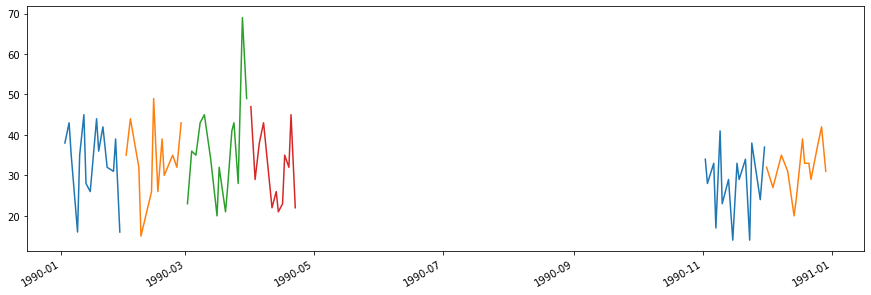

In [201]:
mj_1990.PTS.resample(rule='M').plot(figsize=(15,5))

In [220]:
mj_1990.resample(rule='M',convention='end').mean()

FGA       FG%        3P       3PA       3P%        FT  \
Date                                                                      
1990-01-31  24.933333  0.504333  1.466667  4.066667  0.258533  7.066667   
1990-02-28  25.000000  0.509583  0.500000  1.666667  0.227273  8.000000   
1990-03-31  24.533333  0.549600  1.266667  3.400000  0.384400  8.066667   
1990-04-30  22.916667  0.551583  1.250000  3.500000  0.340250  5.166667   
1990-05-31        NaN       NaN       NaN       NaN       NaN       NaN   
1990-06-30        NaN       NaN       NaN       NaN       NaN       NaN   
1990-07-31        NaN       NaN       NaN       NaN       NaN       NaN   
1990-08-31        NaN       NaN       NaN       NaN       NaN       NaN   
1990-09-30        NaN       NaN       NaN       NaN       NaN       NaN   
1990-10-31        NaN       NaN       NaN       NaN       NaN       NaN   
1990-11-30  20.600000  0.558133  0.133333  0.600000  0.222167  5.466667   
1990-12-31  22.428571  0.574500  0.214286  0.928571  0.312500  6.071429   

                 FTA       FT%       ORB       DRB       TRB       AST  \
Date                                                                     
1990-01-31  8.333333  0.849533  1.666667  5.333333  7.000000  6.466667   
1990-02-28  9.500000  0.833250  1.250000  3.833333  5.083333  5.916667   
1990-03-31  9.266667  0.836429  2.200000  5.866667  8.066667  5.933333   
1990-04-30  6.333333  0.724500  1.666667  4.666667  6.333333  6.500000   
1990-05-31       NaN       NaN       NaN       NaN       NaN       NaN   
1990-06-30       NaN       NaN       NaN       NaN       NaN       NaN   
1990-07-31       NaN       NaN       NaN       NaN       NaN       NaN   
1990-08-31       NaN       NaN       NaN       NaN       NaN       NaN   
1990-09-30       NaN       NaN       NaN       NaN       NaN       NaN   
1990-10-31       NaN       NaN       NaN       NaN       NaN       NaN   
1990-11-30  6.533333  0.831333  1.666667  4.400000  6.066667  6.266667   
1990-12-31  7.142857  0.855571  2.500000  5.214286  7.714286  5.857143   

                 STL       BLK       TOV        PF        PTS       GmSc  
Date                                                                      
1990-01-31  3.066667  0.600000  3.200000  2.800000  33.733333  27.273333  
1990-02-28  1.666667  0.500000  3.750000  2.833333  33.833333  24.100000  
1990-03-31  3.800000  0.733333  2.133333  2.933333  36.400000  32.620000  
1990-04-30  3.083333  1.000000  2.916667  3.583333  31.916667  27.058333  
1990-05-31       NaN       NaN       NaN       NaN        NaN        NaN  
1990-06-30       NaN       NaN       NaN       NaN        NaN        NaN  
1990-07-31       NaN       NaN       NaN       NaN        NaN        NaN  
1990-08-31       NaN       NaN       NaN       NaN        NaN        NaN  
1990-09-30       NaN       NaN       NaN       NaN        NaN        NaN  
1990-10-31       NaN       NaN       NaN       NaN        NaN        NaN  
1990-11-30  2.733333  0.666667  2.133333  2.733333  28.533333  25.120000  
1990-12-31  2.857143  1.285714  2.214286  2.857143  31.857143  28.657143

### *Below are use cases for non-DateTimeIndex dataframes*

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

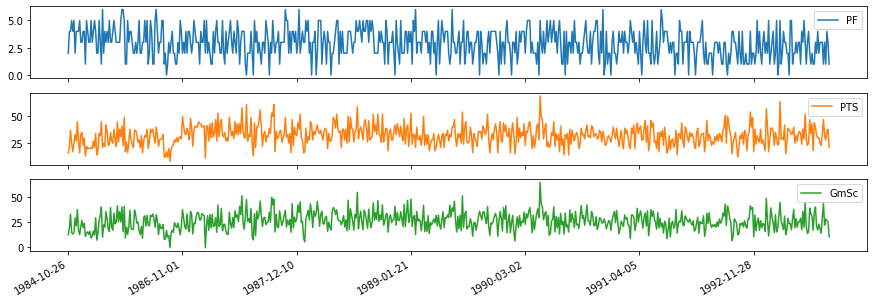

In [241]:
# Change index to strings so plotting becomes categorical
# When using DateTimeIndex, the date logic imputes dates that have no data
# which creates large gaps in the graph
mj_str_index = mj.set_index(pd.Series(mj.index.format()))
mj_str_index[cols[25:]].plot(figsize=(15,5),subplots=True)

In [242]:
# Index df with MultiIndex made up of year, month, date of records
date_index_arrays = [mj_1990.index.year, mj_1990.index.month, mj_1990.index.day]
mi = pd.MultiIndex.from_arrays(date_index_arrays)
mj_1990_mi = mj_1990.set_index(mi)
mj_1990_mi.index[:5]

MultiIndex([(1990, 1,  3),
            (1990, 1,  5),
            (1990, 1,  6),
            (1990, 1,  9),
            (1990, 1, 10)],
           names=['Date', 'Date', 'Date'])